In [ ]:
https://wiserloner.tistory.com/1244

In [1]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = './art_classification/'

train = os.path.join(path, 'train')
test = os.path.join(path, 'test/0')
train, test

('./art_classification/train', './art_classification/test/0')

In [ ]:
train = pathlib.Path(train)
train_im = train /'person'/'pic_001.jpg'
train_im

In [ ]:
sample = tf.io.decode_jpeg(tf.io.read_file(str(train_im)))
plt.imshow(sample), sample.shape

In [ ]:
sample = tf.expand_dims(sample, 0)
sample

In [ ]:
labels = os.listdir(train)
label = {i:labels.index(i)  for i in labels}
label

In [3]:
weight = 227
height = 227
channel = 3
autotune = tf.data.experimental.AUTOTUNE
seed = 42

In [ ]:
def jitter(x, y):
    x_resize = tf.image.resize(x, (256, 256))
    x_crop = tf.image.random_crop(x_resize, (, weight, height, 3))
    return x_crop,y

In [ ]:
def norm(x, y):
    x, y = x / 255, y
    return x, y

In [49]:
# batch_size = 32 : default
trainset = tf.keras.preprocessing.image_dataset_from_directory(train, 
                                                           image_size=(weight, height),
                                                           validation_split=.3,
                                                           subset='training',
                                                           seed=seed, batch_size=10)

Found 1698 files belonging to 7 classes.
Using 1189 files for training.


In [5]:
class_name = trainset.class_names
class_name

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

In [50]:
trainset = trainset.cache().prefetch(autotune)

In [51]:
next(iter(trainset))[0].shape

TensorShape([10, 227, 227, 3])

In [52]:
valset = tf.keras.preprocessing.image_dataset_from_directory(train, 
                                                           image_size=(weight, height),
                                                           validation_split=.3,
                                                           subset='validation',
                                                           seed=seed, batch_size=10)

Found 1698 files belonging to 7 classes.
Using 509 files for validation.


In [53]:
valset = valset.cache().prefetch(autotune)

In [38]:
augmentor = tf.keras.Sequential([
    
        tf.keras.layers.experimental.preprocessing.RandomFlip(input_shape = (weight, height, channel)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        
    ])

In [12]:
norm = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)

In [ ]:
input_ = tf.keras.Input((weight, height, channel))

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(input_)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(64,3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(7)(x)
output = tf.keras.layers.Activation('softmax')(x)

In [ ]:
model1 = tf.keras.models.Model(input_, output)

In [39]:
input_ = tf.keras.Input((weight, height, channel))

x = augmentor(input_)
x = norm(x)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(7)(x)
output = tf.keras.layers.Activation('softmax')(x)

In [40]:
model2 = tf.keras.models.Model(input_, output)

In [41]:
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 227, 227, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 227, 227, 128)     3584      
_________________________________________________________________
batch_normalization_9 (Batch (None, 227, 227, 128)     512       
_________________________________________________________________
activation_18 (Activation)   (None, 227, 227, 128)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 227, 227, 64)      7379

In [42]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience =30)

In [43]:
# CategoricalCrossentropy : y값이 원핫인코딩이 되어있어야함
# SparseCategoricalCrossentropy :y값이 int 형태

model2.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', 
               metrics=['acc'])

In [46]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: # Currently, memory growth needs to be the same across GPUs 
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True) 
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: 
        # Memory growth must be set before GPUs have been initialized 
        print(e)

Physical devices cannot be modified after being initialized


In [54]:
history = model2.fit(trainset, validation_data=valset, epochs=100, callbacks=es)

Epoch 1/100
119/119 [==============================] - 49s 410ms/step - loss: 1.8813 - acc: 0.2389 - val_loss: 1.9244 - val_acc: 0.2593
Epoch 2/100
119/119 [==============================] - 48s 404ms/step - loss: 1.8114 - acc: 0.2775 - val_loss: 1.9103 - val_acc: 0.2672
Epoch 3/100
119/119 [==============================] - 48s 405ms/step - loss: 1.7604 - acc: 0.3070 - val_loss: 1.8730 - val_acc: 0.2809
Epoch 4/100
119/119 [==============================] - 48s 406ms/step - loss: 1.7530 - acc: 0.3137 - val_loss: 1.8828 - val_acc: 0.1925
Epoch 5/100
119/119 [==============================] - 48s 406ms/step - loss: 1.7356 - acc: 0.3347 - val_loss: 1.7988 - val_acc: 0.2809
Epoch 6/100
119/119 [==============================] - 48s 406ms/step - loss: 1.7182 - acc: 0.3288 - val_loss: 1.9173 - val_acc: 0.2397
Epoch 7/100
119/119 [==============================] - 48s 406ms/step - loss: 1.7026 - acc: 0.3465 - val_loss: 1.9596 - val_acc: 0.3084
Epoch 8/100
119/119 [===========================

Epoch 61/100
119/119 [==============================] - 48s 402ms/step - loss: 1.3296 - acc: 0.5046 - val_loss: 2.2024 - val_acc: 0.3202
Epoch 62/100
119/119 [==============================] - 48s 402ms/step - loss: 1.3476 - acc: 0.4996 - val_loss: 2.0299 - val_acc: 0.3222
Epoch 63/100
119/119 [==============================] - 48s 402ms/step - loss: 1.3460 - acc: 0.4861 - val_loss: 1.7810 - val_acc: 0.3536
Epoch 64/100
119/119 [==============================] - 48s 403ms/step - loss: 1.3574 - acc: 0.4861 - val_loss: 1.9073 - val_acc: 0.3360
Epoch 65/100
119/119 [==============================] - 48s 406ms/step - loss: 1.3435 - acc: 0.4861 - val_loss: 1.7428 - val_acc: 0.3969
Epoch 66/100
119/119 [==============================] - 48s 405ms/step - loss: 1.3253 - acc: 0.4954 - val_loss: 1.7453 - val_acc: 0.3713
Epoch 67/100
119/119 [==============================] - 48s 405ms/step - loss: 1.3054 - acc: 0.5198 - val_loss: 3.0679 - val_acc: 0.2692
Epoch 68/100
119/119 [===================

In [55]:
model2.evaluate(valset)

51/51 [==============================] - 3s 57ms/step - loss: 1.9311 - acc: 0.3752


[1.9310688972473145, 0.3752455711364746]

In [56]:
test = pathlib.Path(test)
test_im = test / '0077.jpg'
test_im

WindowsPath('art_classification/test/0/0077.jpg')

(<matplotlib.image.AxesImage at 0x1d3b022ba90>, TensorShape([227, 227, 3]))

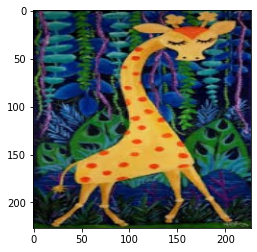

In [57]:
sample = tf.io.decode_jpeg(tf.io.read_file(str(test_im)))
plt.imshow(sample), sample.shape

In [58]:
sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = tf.expand_dims(sample, 0)

In [59]:
prediction = model2.predict(sample)
score = tf.nn.softmax(prediction[0])

In [60]:
score

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.26927754, 0.13699006, 0.11902824, 0.11812849, 0.11882287,
       0.11835983, 0.119393  ], dtype=float32)>

In [61]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dog with a 26.93 percent confidence.


In [62]:
class_name

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']